<a href="https://colab.research.google.com/github/Dhaneesh02/fyp/blob/main/msp_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### General imports ###
import os
from glob import glob
import pickle
import itertools
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline
### Graph imports ###
from PIL import Image
import librosa
### Audio import ###

import IPython
from IPython.display import Audio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install pydub
from pydub import AudioSegment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import csv
from dataclasses import dataclass
from pydub import AudioSegment
file_path = '/content/drive/MyDrive/Review_3/'
file = open(file_path+"filtered_annotations_msp_3500.csv")
csvreader = csv.reader(file)
header = next(csvreader)
# print(header)
csv_data = []
for row in csvreader:
    csv_data.append(row)

file.close()
labelling_data = dict()

for i in csv_data:
    labelling_data[i[0]]=i[1]
    
  
print(len(csv_data))

3500


In [ ]:
# # Start feature extraction
# print("Import Data: START")

# # Audio file path and names
# file_path = '/content/drive/MyDrive/Review_3/Data_msp_3500/'

# # Initialize features and labels list
# signal = []
# labels = []

# # Sample rate (16.0 kHz)
# sample_rate = 16000     

# # Max pad length (10.0 sec)
# max_pad_len = 163333


# file_names=[]

# #data_visualisation
# count = 0

# max_=0
# print("Import Data: RUNNING ... files")
# for i in labelling_data:
#   cur_file = file_path + i
#   y, sr = librosa.core.load(cur_file, sr=sample_rate, offset=0)
#   y = zscore(y)
#   # print(len(y))
#   if len(y) < max_pad_len:    
#     y_padded = np.zeros(max_pad_len)
#     y_padded[:len(y)] = y
#     y = y_padded
#   elif len(y) > max_pad_len:
#       y = np.asarray(y[:max_pad_len])

#   signal.append(y)
#   labels.append(labelling_data[i])

#   file_names.append(i)
#   if count%400 == 0:
#     print(count)
#   # if count==300:
#   #   break
#   count += 1
# # Cast labels to array
# labels = np.asarray(labels).ravel()

# # Stop feature extraction
# print("Import Data: END \n")
# print("Number of audio files imported: {}".format(labels.shape[0]),"  ",count)


In [ ]:
# file_path = '/content/drive/MyDrive/Review_3/'
# pickle.dump(signal, open(file_path+'signal.p', 'wb'))
# pickle.dump(file_names, open(file_path+'file_names.p', 'wb'))
# pickle.dump(labels, open(file_path+'labels.p', 'wb'))

In [ ]:
file_path = '/content/drive/MyDrive/Review_3/'

# Initialize features and labels list
signal = []
labels = []
file_names = []

# Sample rate (16.0 kHz)
sample_rate = 16000     

# Max pad length (3.0 sec)
max_pad_len = 49100


signal=pickle.load(open(file_path+"signal.p","rb"))
file_names=pickle.load(open(file_path+"file_names.p","rb"))
labels=pickle.load(open(file_path+"labels.p","rb"))

#data_visualisation
count = len(signal)
print("Import Data: END \n")
print("Number of audio files imported: {}".format(labels.shape[0]))

Import Data: END 

Number of audio files imported: 3500


In [ ]:
# Number of augmented data
nb_augmented = 1
# Function to add noise to a signals with a desired Signal Noise ratio (SNR)
def noisy_signal(signal, snr_low=15, snr_high=30, nb_augmented=1):
    # Signal length
    signal_len = len(signal)

    # Generate White noise
    noise = np.random.normal(size=(nb_augmented, signal_len))
    
    # Compute signal and noise power
    s_power = np.sum((signal / (2.0 ** 15)) ** 2) / signal_len
    n_power = np.sum((noise / (2.0 ** 15)) ** 2, axis=1) / signal_len
    
    # Random SNR: Uniform [15, 30]
    snr = np.random.randint(snr_low, snr_high)
    
    # Compute K coeff for each noise
    K = np.sqrt((s_power / n_power) * 10 ** (- snr / 10))
    K = np.ones((signal_len, nb_augmented)) * K
    
    # Generate noisy signal
    return signal + K.T * noise

In [ ]:
# Generate noisy signals from signal list
print("Data Augmentation: START")
# augmented_signal = list(map(noisy_signal, signal))
c=0
print(len(signal))
augmented_signal = []
for i in signal:
  augmented_signal.append(noisy_signal(i)[0])
  if c%300==0:
    print(c)
  c+=1
print("Data Augmentation: END!")
print(len(augmented_signal))

In [ ]:
g=0
def mel_spectrogram(y, sr=16000, n_fft=512, win_length=256, hop_length=128, window='hamming', n_mels=128, fmax=4000):
    global g
    if g%300==0:
      print(g) 
    g+=1
    # Compute spectogram
    mel_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2
    
    # Compute mel spectrogram
    mel_spect = librosa.feature.melspectrogram(S=mel_spect, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Compute log-mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    
    return mel_spect

In [ ]:
import gc

In [ ]:
# Start feature extraction
print("Feature extraction: START")

# Compute spectogram for all audio file
mel_spect = []
# print(len(signal),len(s))
for i in range(len(signal)):
  mel_spect.append(mel_spectrogram(signal[i]))


mel_spect = np.asarray(mel_spect)
del signal
gc.collect()

# Stop feature extraction
print("Feature extraction: END!")

Feature extraction: START
0
300
600
900
1200
1500
1800
2100
2400
2700
3000
3300
Feature extraction: END!


In [ ]:
# Start feature extraction
print("Feature extraction: START")

augmented_mel_spect = []
for i in range(len(augmented_signal)):
  augmented_mel_spect.append(mel_spectrogram(augmented_signal[i]))
augmented_mel_spect =  np.asarray(augmented_mel_spect)
del augmented_signal
gc.collect()

# Stop feature extraction
print("Feature extraction: END!")

Feature extraction: START
3600
3900
4200
4500
4800
5100
5400
5700
6000
6300
6600
6900
Feature extraction: END!


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:

print(mel_spect.shape)
print(augmented_mel_spect.shape)
print(labels.shape)

(3500, 128, 1277)
(3500,)


In [ ]:
# file_path = '/content/drive/MyDrive/Review_3/'
# pickle.dump(augmented_mel_spect, open(file_path+'augmented_mel_spect.p', 'wb'), protocol=4)
# pickle.dump(mel_spect, open(file_path+'mel_spect.p', 'wb'), protocol=4)


In [ ]:
file_path = '/content/drive/MyDrive/Review_3/'
# augmented_mel_spect=pickle.load(open(file_path+"augmented_mel_spect.p","rb"))
mel_spect=pickle.load(open(file_path+"mel_spect.p","rb"))
labels=pickle.load(open(file_path+"labels.p","rb"))

In [ ]:
labels=pickle.load(open(file_path+"labels.p","rb"))

In [ ]:
# Build Train and test dataset
MEL_SPECT_train, MEL_SPECT_test,  label_train, label_test = train_test_split(mel_spect,  labels, test_size=0.2)
# MEL_SPECT_train, MEL_SPECT_test, AUG_MEL_SPECT_train, AUG_MEL_SPECT_test, label_train, label_test = train_test_split(mel_spect, augmented_mel_spect, labels, test_size=0.2)

# Build augmented labels and train
# aug_label_train = np.asarray(list(itertools.chain.from_iterable([[label] * nb_augmented for label in label_train])))
# AUG_MEL_SPECT_train = np.asarray(list(itertools.chain.from_iterable(AUG_MEL_SPECT_train)))
# AUG_MEL_SPECT_test = np.asarray(list(itertools.chain.from_iterable(AUG_MEL_SPECT_test)))
# aug_label_test = np.asarray(list(itertools.chain.from_iterable([[label] * nb_augmented for label in label_test])))
# print(AUG_MEL_SPECT_train.shape)
# print(AUG_MEL_SPECT_test.shape)
# Concatenate original and augmented
X_train = MEL_SPECT_train
y_train = label_train
# X_train = np.concatenate((MEL_SPECT_train, AUG_MEL_SPECT_train))
# y_train = np.concatenate((label_train, label_train))

print("x_train: ",X_train.shape)
print("y_train: ",y_train.shape)
# Build test set
# X_test = np.concatenate((MEL_SPECT_test, AUG_MEL_SPECT_test))
X_test = MEL_SPECT_test
# y_test = np.concatenate((label_test, label_test))
y_test = label_test
print(X_test.shape)
print(y_test.shape)
# Delete
del MEL_SPECT_train,MEL_SPECT_test
# del MEL_SPECT_train, AUG_MEL_SPECT_train, label_train, AUG_MEL_SPECT_test, MEL_SPECT_test, label_test
# del mel_spect, augmented_mel_spect, labels

x_train:  (2800, 128, 1277)
y_train:  (2800,)
(700, 128, 1277)
(700,)


In [ ]:
win_ts = 128
hop_ts = 64

def frame(x, win_step=128, win_size=64):
    nb_frames = 1 + int((x.shape[2] - win_size) / win_step)
    frames = np.zeros((x.shape[0], nb_frames, x.shape[1], win_size)).astype(np.float32)
    for t in range(nb_frames):
        frames[:,t,:,:] = np.copy(x[:,:,(t * win_step):(t * win_step + win_size)]).astype(np.float32)
    return frames

X_train = frame(X_train, hop_ts, win_ts)
X_test = frame(X_test, hop_ts, win_ts)


In [ ]:

X_test.shape

(700, 18, 128, 128)

In [ ]:
# Save Train and test set
file_path = '/content/drive/MyDrive/Review_3/'
pickle.dump(X_train.astype(np.float16), open(file_path+'[msp_mfcc][X_train].p', 'wb'))
pickle.dump(y_train, open(file_path+'[msp_mfcc][y_train].p', 'wb'))
pickle.dump(X_test.astype(np.float16), open(file_path+'[msp_mfcc][X_test].p', 'wb'))
pickle.dump(y_test, open(file_path+'[msp_mfcc][y_test].p', 'wb'))

In [ ]:
import os
from glob import glob
import pickle
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
### Plot imports ###
from IPython.display import Image
import matplotlib.pyplot as plt

### Time Distributed ConvNet imports ###
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder

### Warning ###
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Review_3/'
X_train = pickle.load(open(file_path+'[msp_mfcc][X_train].p', 'rb'))
y_train = pickle.load(open(file_path+'[msp_mfcc][y_train].p', 'rb'))
y_test = pickle.load(open(file_path+'[msp_mfcc][y_test].p', 'rb'))
X_test = pickle.load(open(file_path+'[msp_mfcc][X_test].p', 'rb'))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2800, 18, 128, 128)
(2800,)
(700, 18, 128, 128)
(700,)


In [ ]:
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(np.ravel(y_train)))
y_test = np_utils.to_categorical(lb.transform(np.ravel(y_test)))

In [ ]:
# Reshape for convolution
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , X_test.shape[2], X_test.shape[3], 1)

In [ ]:
X_train.shape[1:]

(18, 128, 128, 1)

In [ ]:
K.clear_session()

input_y = Input(shape=X_train.shape[1:], name='Input_MELSPECT')

y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same'), name='Conv_1_MELSPECT')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_1_MELSPECT')(y)     

y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_2_MELSPECT')(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_3_MELSPECT')(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_4_MELSPECT')(y)  

y = TimeDistributed(Flatten(), name='Flat_MELSPECT')(y)                                           
# Apply 2 LSTM layer and one FC
y = LSTM(256, return_sequences=False, dropout=0.2, name='LSTM_1')(y)
y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

# Build final model
model = Model(inputs=input_y, outputs=y)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_MELSPECT (InputLayer)  [(None, 18, 128, 128, 1)  0        
                             ]                                   
                                                                 
 Conv_1_MELSPECT (TimeDistri  (None, 18, 128, 128, 64)  640      
 buted)                                                          
                                                                 
 BatchNorm_1_MELSPECT (TimeD  (None, 18, 128, 128, 64)  256      
 istributed)                                                     
                                                                 
 Activ_1_MELSPECT (TimeDistr  (None, 18, 128, 128, 64)  0        
 ibuted)                                                         
                                                                 
 MaxPool_1_MELSPECT (TimeDis  (None, 18, 64, 64, 64)   0     

In [ ]:
file_path = '/content/drive/MyDrive/Review_3/'

In [ ]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [ ]:
# Compile model
model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint(file_path+'msp_CNN_LSTM_Model_1.hdf5', save_best_only=True, monitor='accuracy', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='accuracy', patience=30, verbose=1, mode='max')

# Fit model
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save,tf.keras.callbacks.CSVLogger(file_path+'msp_mel_source_history_1.csv')])

Epoch 1/30
88/88 [==============================] - 434s 5s/step - loss: 1.4364 - accuracy: 0.4429 - val_loss: 2.1882 - val_accuracy: 0.2257
Epoch 2/30
88/88 [==============================] - 438s 5s/step - loss: 1.4207 - accuracy: 0.4614 - val_loss: 2.4764 - val_accuracy: 0.2314
Epoch 3/30
88/88 [==============================] - 531s 6s/step - loss: 1.4210 - accuracy: 0.4546 - val_loss: 2.1615 - val_accuracy: 0.2357
Epoch 4/30
88/88 [==============================] - 449s 5s/step - loss: 1.4120 - accuracy: 0.4600 - val_loss: 2.5460 - val_accuracy: 0.2200
Epoch 5/30
88/88 [==============================] - 430s 5s/step - loss: 1.4092 - accuracy: 0.4564 - val_loss: 2.4086 - val_accuracy: 0.2914
Epoch 6/30
88/88 [==============================] - 461s 5s/step - loss: 1.4041 - accuracy: 0.4514 - val_loss: 1.9253 - val_accuracy: 0.3143
Epoch 7/30
88/88 [==============================] - 472s 5s/step - loss: 1.4046 - accuracy: 0.4654 - val_loss: 2.1631 - val_accuracy: 0.2371
Epoch 8/30
88

In [ ]:
model.evaluate(X_test,y_test)

22/22 [==============================] - 16s 724ms/step - loss: 1.7057 - accuracy: 0.3586


[1.705717921257019, 0.35857143998146057]

In [ ]:
y_pred=model.predict(X_test)
y_classes = y_pred.argmax(axis=-1)

In [ ]:
np.unique(y_classes)

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
model.save(file_path+'msp_mfcc_[CNN-LSTM]Model_1.h5')
model.save_weights(file_path+'msp_mfcc_[CNN-LSTM]Model_Weights_1.h5')

In [ ]:
history={}
history["history"] = pd.read_csv(file_path+'msp_mel_source_history.csv')
history["history"].head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.227143,1.848003,0.161429,2.292064
1,1,0.266786,1.762734,0.155714,2.129855
2,2,0.269643,1.728160,0.262857,1.886325
3,3,0.286429,1.717352,0.195714,1.996854
4,4,0.307143,1.688442,0.227143,2.237848


Text(0, 0.5, 'Accuracy')

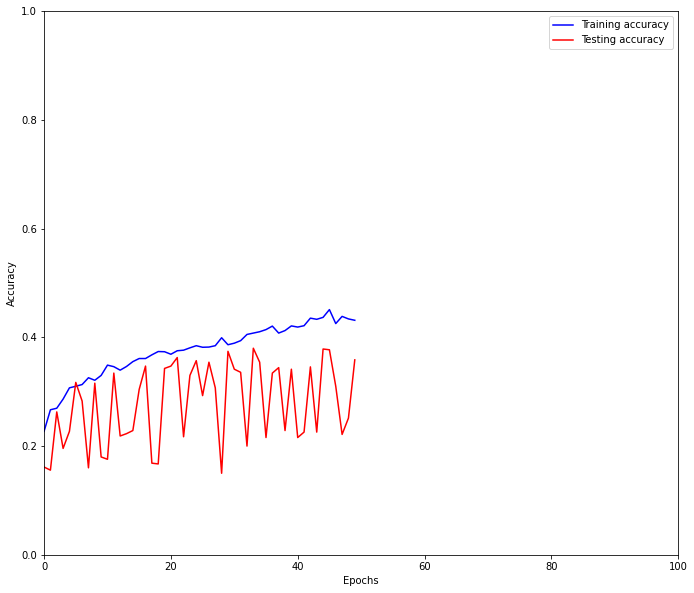

In [ ]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(history['history']['accuracy'],'-b')
plt.plot(history['history']['val_accuracy'],'r')
plt.legend(['Training accuracy','Testing accuracy'])
plt.axis([0, 100, 0, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [ ]:

from sklearn.metrics import accuracy_score
# Calculating the accuracy of classifier
print(f"Accuracy of the classifier is: {accuracy_score(y_test,y_pred)}")

ValueError: ignored

In [ ]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
y_pred

array([[0.089663  , 0.1195804 , 0.04502108, ..., 0.01555423, 0.12335699,
        0.38429728],
       [0.02045113, 0.03458054, 0.02588117, ..., 0.11646038, 0.08021235,
        0.11991537],
       [0.04459757, 0.08095468, 0.01929124, ..., 0.27888373, 0.22942632,
        0.1001474 ],
       ...,
       [0.00808379, 0.01006213, 0.12515593, ..., 0.2948725 , 0.4668768 ,
        0.07453395],
       [0.05919861, 0.13838032, 0.03151379, ..., 0.14772676, 0.07005911,
        0.06799781],
       [0.07394176, 0.11126915, 0.03271666, ..., 0.36532915, 0.15108375,
        0.12769905]], dtype=float32)

In [ ]:
import numpy as np
y_pred_1=np.around(y_pred, decimals=1)
y_pred_1

NameError: ignored